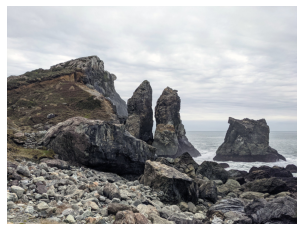

In [19]:
# テスト画像を取得
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
# base_image_path = "dream1.png"

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [20]:
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [21]:
layer_settings = {
  "mixed4": 1.0,
  "mixed5": 1.5,
  "mixed6": 2.0,
  "mixed7": 2.5,
}

outputs_dict = dict([
  (layer.name, layer.output)
  for layer in [model.get_layer(name) for name in layer_settings.keys()]
])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [22]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]

    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
  return loss

In [23]:
@tf.function
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, image = (gradient_ascent_step(image, learning_rate))

    if max_loss is not None and loss > max_loss:
      break
    print(f"... Loss value at atep{i}: {loss:.2f}")
  return image

In [24]:
import numpy as np

def preprocess_image(iamge_path):
  img = keras.utils.load_img(iamge_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))

  img /= 2.0
  img += 0.5
  img *= 255.

  img = np.clip(img, 0, 255).astype("uint8")
  return img

In [25]:
step = 20
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [26]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

succesive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  succesive_shapes.append(shape)
succesive_shapes = succesive_shapes[::1]

shrunk_original_image = tf.image.resize(original_img, succesive_shapes[0])

img = tf.identity(original_img)

for i, shape in enumerate(succesive_shapes):
  print(f"Processing octave {i} with shape {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(
    img, iterations=iterations, learning_rate=step, max_loss=max_loss
  )

  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_image, shape)

  same_size_original = tf.image.resize(original_img, shape)

  lost_detail = same_size_original - upscaled_shrunk_original_img

  img += lost_detail
  shrunk_original_image = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (900, 1200)
... Loss value at atep0: 0.65
... Loss value at atep1: 0.83
... Loss value at atep2: 1.06
... Loss value at atep3: 1.34
... Loss value at atep4: 1.61
... Loss value at atep5: 1.87
... Loss value at atep6: 2.14
... Loss value at atep7: 2.41
... Loss value at atep8: 2.68
... Loss value at atep9: 2.95
... Loss value at atep10: 3.23
... Loss value at atep11: 3.51
... Loss value at atep12: 3.81
... Loss value at atep13: 4.09
... Loss value at atep14: 4.36
... Loss value at atep15: 4.66
... Loss value at atep16: 4.91
... Loss value at atep17: 5.24
... Loss value at atep18: 5.53
... Loss value at atep19: 5.79
... Loss value at atep20: 6.06
... Loss value at atep21: 6.50
... Loss value at atep22: 6.69
... Loss value at atep23: 7.13
... Loss value at atep24: 7.35
... Loss value at atep25: 7.78
... Loss value at atep26: 8.07
... Loss value at atep27: 8.41
... Loss value at atep28: 8.75
... Loss value at atep29: 9.04
Processing octave 1 with shape (642, 

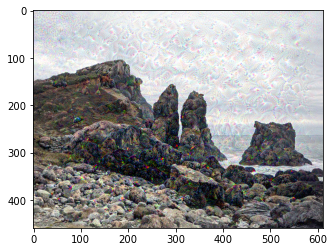

In [27]:
plt.imshow(keras.utils.load_img("dream.png"))